### imports & loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from scipy.stats import ttest_rel

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

In [2]:
df = pd.read_parquet('/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/codesearchnet/baseline/dres/BAAI_bge-base-en/text_fields_swapped/augmented_retrieval_analysis.parquet')

In [3]:
df.columns

Index(['query_id', 'query', 'retrieved_doc_id', 'retrieved_doc',
       'retrieved_code', 'retrieved_explanation', 'score',
       'ground_truth_relevance'],
      dtype='object')

In [4]:
len(df) # 14918 queries and top 1000 (k=1000) so we have 14918000

14918000

In [5]:
df.head()

,query_id,query,retrieved_doc_id,retrieved_doc,retrieved_code,retrieved_explanation,score,ground_truth_relevance
0,q265734,str->list\n Convert XML to URL List.\n F...,c265861,Waits for the named operation to complete - ch...,"def _wait_for_operation_to_complete(self, proj...",The code is designed to wait for a named opera...,0.905614,0
1,q265734,str->list\n Convert XML to URL List.\n F...,c265880,Send an email with html content using sendgrid...,"def send_email(to, subject, html_content, file...",The task is to send an email with HTML content...,0.869492,0
2,q265734,str->list\n Convert XML to URL List.\n F...,c113652,Issues a request to retrieve information about...,"def jobs_get(self, job_id, project_id=None):\n...",The doc and code mean that a method called job...,0.862569,0
3,q265734,str->list\n Convert XML to URL List.\n F...,c265864,Checks that a prefix exists in a bucket\n\n ...,"def check_for_prefix(self, bucket_name, prefix...","``<think>Okay, so I need to figure out how to ...",0.862003,0
4,q265734,str->list\n Convert XML to URL List.\n F...,c265863,Creates an Amazon S3 bucket.\n\n :param...,"def create_bucket(self, bucket_name, region_na...","``<think>Okay, let me try to figure this out. ...",0.856783,0


In [6]:
df.describe()

,score,ground_truth_relevance
count,1.491800e+07,1.491800e+07
mean,8.348197e-01,8.848371e-06
std,1.635418e-02,2.974608e-03
min,7.613598e-01,0.000000e+00
25%,8.238997e-01,0.000000e+00
50%,8.340938e-01,0.000000e+00
75%,8.449850e-01,0.000000e+00
max,9.701887e-01,1.000000e+00


In [7]:
ground_truth_map = df[df["ground_truth_relevance"] == 1].set_index("query")["retrieved_explanation"].to_dict()

df["ground_truth_explanation"] = df["query"].map(ground_truth_map).fillna("")

# if for a query ground truth is not in top 1000 then this col will be marked as ""

In [8]:
df.isna().sum()

query_id                         0
query                       216000
retrieved_doc_id                 0
retrieved_doc                    0
retrieved_code                   0
retrieved_explanation            0
score                            0
ground_truth_relevance           0
ground_truth_explanation         0
dtype: int64

### How many docs before the first ground truth appears?

In [9]:
ground_truth_ranks = []

for query_id, group in df.groupby("query_id"):
    group = group.reset_index()  
    first_index = group.index[0] 
    
    # Find ground truth occurrences
    relevant_docs = group[group["ground_truth_relevance"] == 1]
    
    if not relevant_docs.empty:
        first_gt_rank = relevant_docs.index.min() - first_index + 1  # Rank calculation
        total_relevant = len(relevant_docs)
    else:
        first_gt_rank = 1001
        total_relevant = 0

    ground_truth_ranks.append({
        "Query ID": query_id,
        "First GT Rank": first_gt_rank,
        "Total GT": total_relevant
    })
    
result_df = pd.DataFrame(ground_truth_ranks)
result_df.head()

,Query ID,First GT Rank,Total GT
0,q265734,1001,0
1,q265735,1001,0
2,q265736,1001,0
3,q265737,1001,0
4,q265738,1001,0


In [10]:
valid_ranks = result_df[result_df["First GT Rank"] != 1001]["First GT Rank"]

average_first_gt_rank = valid_ranks.mean()

print(f"Average First GT Rank: {average_first_gt_rank:.4f}")

Average First GT Rank: 403.7197


In [11]:
result_df['First GT Rank'].describe()

count    14918.000000
mean       995.715042
std         62.503215
min          1.000000
25%       1001.000000
50%       1001.000000
75%       1001.000000
max       1001.000000
Name: First GT Rank, dtype: float64

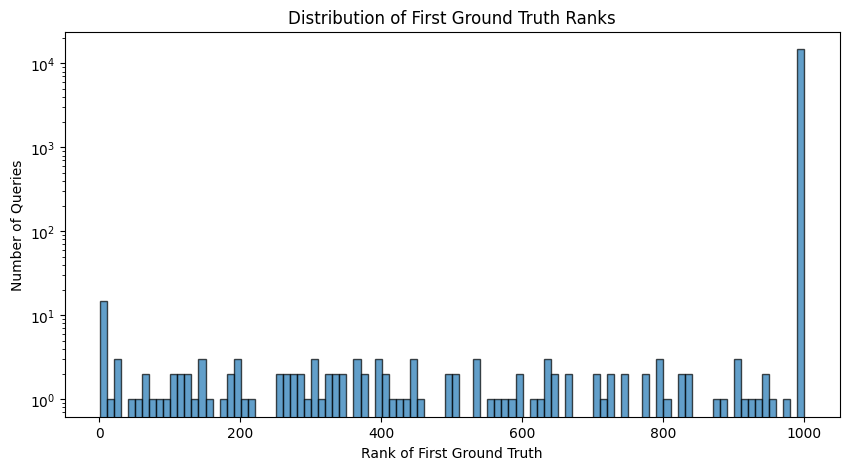

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(result_df['First GT Rank'], bins=np.arange(1, 1002, 10), edgecolor="black", alpha=0.7)
plt.xlabel("Rank of First Ground Truth")
plt.ylabel("Number of Queries")
plt.title("Distribution of First Ground Truth Ranks")
plt.yscale("log")  
plt.show()


In [13]:
invalid_ranks = result_df[result_df["First GT Rank"] == 1001]["First GT Rank"]
print(f"Queries for which GT not retrieved: {len(invalid_ranks)} out of {len(result_df)} ({len(invalid_ranks)/len(result_df) * 100})%")

Queries for which GT not retrieved: 14786 out of 14918 (99.11516289046789)%


In [14]:
first_gt_ranks = result_df['First GT Rank'].tolist()

mrr = np.mean([1/rank for rank in first_gt_ranks if rank <= 1000])
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")


Mean Reciprocal Rank (MRR): 0.0963


### Finding patterns in query results

In [15]:
correct_retrievals = df[df["ground_truth_relevance"] == 1]
incorrect_retrievals = df[df["ground_truth_relevance"] == 0]

/tmp/ipykernel_2226317/4025150044.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(incorrect_retrievals['score'], color='r', label='Incorrect Retrievals', shade=True, alpha=0.6)
/tmp/ipykernel_2226317/4025150044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(correct_retrievals['score'], color='g', label='Correct Retrievals', shade=True, alpha=0.6)


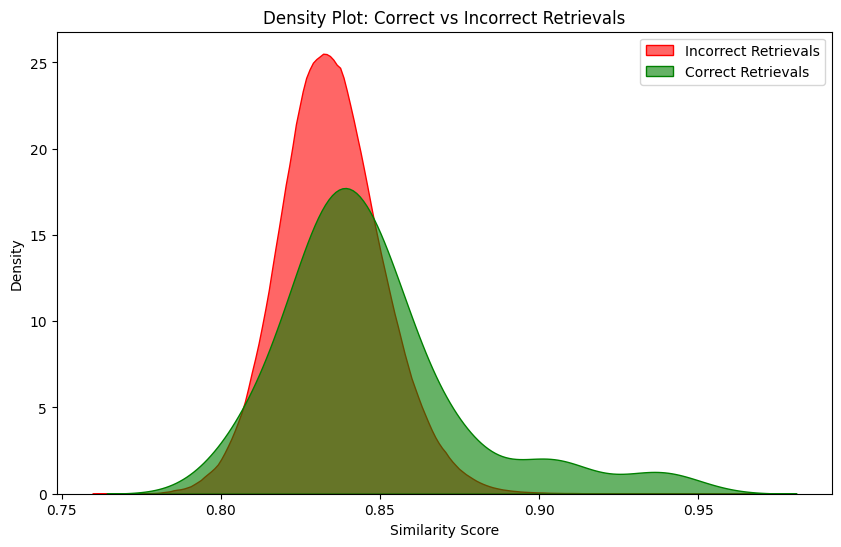

In [16]:
plt.figure(figsize=(10, 6))
sns.kdeplot(incorrect_retrievals['score'], color='r', label='Incorrect Retrievals', shade=True, alpha=0.6)
sns.kdeplot(correct_retrievals['score'], color='g', label='Correct Retrievals', shade=True, alpha=0.6)

plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.title('Density Plot: Correct vs Incorrect Retrievals')
plt.legend()
plt.show()


In [17]:
df['top_retrieved_score'] = df.groupby('query')['score'].transform('max')
df['score_difference'] = df['top_retrieved_score'] - df['score']

In [18]:
df['score_difference'].describe()

count    1.470200e+07
mean     7.014400e-02
std      2.323759e-02
min      0.000000e+00
25%      5.323863e-02
50%      7.002634e-02
75%      8.596301e-02
max      1.676310e-01
Name: score_difference, dtype: float64

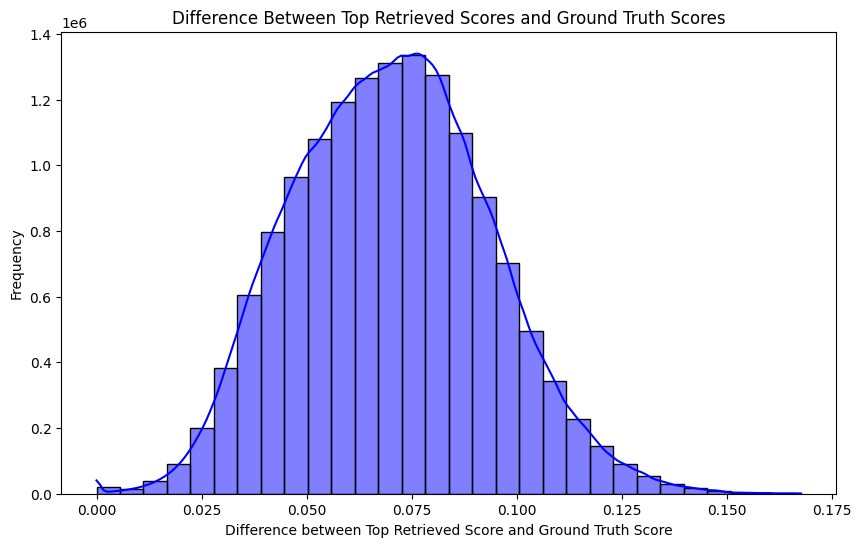

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['score_difference'], bins=30, kde=True, color='b')
plt.xlabel('Difference between Top Retrieved Score and Ground Truth Score')
plt.ylabel('Frequency')
plt.title('Difference Between Top Retrieved Scores and Ground Truth Scores')
plt.show()

### Analyzing Term Frequencies & BM25 Impact

In [20]:
def token_overlap(query, explanation):
    query_tokens = set(word for word in query.lower().split() if word not in stop_words)
    explanation_tokens = set(word for word in explanation.lower().split() if word not in stop_words)
    return len(query_tokens.intersection(explanation_tokens))

In [21]:
df["retrieved_overlap"] = df.apply(lambda row: token_overlap(row["query"], row["retrieved_explanation"]), axis=1)

df["ground_truth_overlap"] = df.apply(lambda row: token_overlap(row["query"], row["ground_truth_explanation"]) , axis=1)

AttributeError: 'NoneType' object has no attribute 'lower'

In [ ]:
df

In [ ]:
print(token_overlap(df['query'][0],df['retrieved_explanation'][0]))

In [ ]:
retrieved_avg = df["retrieved_overlap"].mean()
ground_truth_avg = df["ground_truth_overlap"].mean()

print(f"Average Token Overlap - Retrieved Explanations: {retrieved_avg:.2f}")
print(f"Average Token Overlap - Ground Truth Explanations: {ground_truth_avg:.2f}")

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["retrieved_overlap"], bins=30, color="red", label="Retrieved Explanations", alpha=0.6, kde=True)
sns.histplot(df["ground_truth_overlap"], bins=30, color="green", label="Ground Truth Explanations", alpha=0.6, kde=True)
plt.xlabel("Token Overlap with Query")
plt.ylabel("Frequency")
plt.title("Token Overlap Distribution: Retrieved vs Ground Truth Explanations")
plt.legend()
plt.show()

In [ ]:
avg_query_token_size = df["query"].apply(lambda x: len([word for word in x.lower().split() if word not in stop_words])).mean()

print(f"Average Query Token Size: {avg_query_token_size:.2f}")

In [ ]:
higher_gt_overlap = (df["ground_truth_overlap"] > df["retrieved_overlap"]).sum()
total_rows = len(df)

print(f"Ground Truth Overlap > Retrieved Overlap: {higher_gt_overlap}/{total_rows} ({(higher_gt_overlap/total_rows)*100:.2f}%)")